*Read section 8.2.2 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [38]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.35)

# import the decision tree regressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.ensemble import BaggingRegressor,BaggingClassifier

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, accuracy_score

## Motivation: Bagging Revisited

In Bagging (Bootstrap Aggregating), we:

* Train many trees on different bootstrap samples of the training data.

* Aggregate their predictions by averaging (regression) or voting (classification).

>✅ Bagging helps reduce variance <br>
>⚠️ But if the trees are too similar (i.e., highly correlated), averaging won't help as much.


In [39]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [40]:
X = car.drop(columns=['price'])
y = car['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [41]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', FunctionTransformer(), numerical_feature),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feature)
    ],
    remainder='passthrough'
)

### Let's build a single decision tree and output its performance

In [42]:
# build a single decsision tree regressor
single_tree_regressor = DecisionTreeRegressor(random_state=0)

# pipeline for the single decision tree regressor
pipeline_single_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', single_tree_regressor)
])
# fit the pipeline to the training data
pipeline_single_tree.fit(X_train, y_train)
# make predictions on the test data
y_pred_single_tree = pipeline_single_tree.predict(X_test)
# calculate the RMSE and R^2 score
rmse_single_tree = root_mean_squared_error(y_test, y_pred_single_tree)
r2_single_tree = r2_score(y_test, y_pred_single_tree)
print(f'Single Tree RMSE: {rmse_single_tree:.2f}')
print(f'Single Tree R^2: {r2_single_tree:.2f}')

# calculate the RMSE and R^2 score for the training data
y_pred_train_single_tree = pipeline_single_tree.predict(X_train)
rmse_train_single_tree = root_mean_squared_error(y_train, y_pred_train_single_tree)
r2_train_single_tree = r2_score(y_train, y_pred_train_single_tree)
print(f'Single Tree Train RMSE: {rmse_train_single_tree:.2f}')
print(f'Single Tree Train R^2: {r2_train_single_tree:.2f}')

Single Tree RMSE: 5073.81
Single Tree R^2: 0.91
Single Tree Train RMSE: 0.00
Single Tree Train R^2: 1.00


In [43]:
# single tree depth
tree_depth = pipeline_single_tree.named_steps['tree'].get_depth()
print(f"Depth of the single decision tree: {tree_depth}")

Depth of the single decision tree: 34


### Let's build a bagging tree to reduce the variance

In [44]:
# bagging with bootstrap
bagging_with_bootstrap_regressor = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=0),
    n_estimators=50,
    random_state=42
)

# create a pipeline with the preprocessor and the bagging regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bagging', bagging_with_bootstrap_regressor)
])

# fit the pipeline to the training data
pipeline.fit(X_train, y_train)
# make predictions on the test data
y_pred = pipeline.predict(X_test)
# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE using bootstraping: {rmse:.2f}')
print(f'R^2 using bootstraping: {r2:.2f}')
# calculate the training rmse and r^2 score
y_train_pred = pipeline.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training RMSE using bootstraping: {train_rmse:.2f}')
print(f'Training R^2 using bootstraping: {train_r2:.2f}')

RMSE using bootstraping: 3756.85
R^2 using bootstraping: 0.95
Training RMSE using bootstraping: 1395.75
Training R^2 using bootstraping: 0.99


The test RMSE and R squared was improved a lot using bagging, by default, bootstrape=True, meaning each training set is created using smapling with replacement. let's turn off the bootstrape and see how it affect the bagging performance

In [45]:
bagging_without_bootstrap_regressor = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=0),
    bootstrap=False,
    n_estimators=50,
    random_state=42
)

# create a pipeline with the preprocessor and the bagging regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bagging', bagging_without_bootstrap_regressor)
])

# fit the pipeline to the training data
pipeline.fit(X_train, y_train)
# make predictions on the test data
y_pred = pipeline.predict(X_test)

# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# calculate the training rmse and r^2 score
y_train_pred = pipeline.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training R^2: {train_r2:.2f}')

RMSE: 4667.43
R^2: 0.93
Training RMSE: 0.00
Training R^2: 1.00


As can be observed from the results, the performance of bagging without bootstrap sampling is worse compared to using bootstrap sampling

**Why Bagging Without Bootstrap Performs Worse?**

When `bootstrap=True`, each tree in the ensemble is trained on a different bootstrap sample (random sample with replacement) of the training data. This has two key effects:

* It introduces diversity among the individual trees.

* It reduces correlation between trees.

This diversity is the **core strength** of bagging — while individual trees may be weak or overfit, their errors cancel out when averaged.

**Why Can Bagging Without Bootstrap Still Show Slight Improvement?**

When `bootstrap=False`, you're instructing `BaggingRegressor` to train each tree on the **exact same dataset**. This removes the key source of diversity in bagging — random sampling — and **reduces the variance reduction benefits** typically gained from averaging diverse models.

However, even when all trees are trained on the same data, implementations like `sklearn.tree.DecisionTreeRegressor` may still introduce **internal randomness**. For example:
- When multiple split points result in equal information gain, one may be chosen **randomly**.
- **Ties** in data splits may be broken differently.
- Other **subtle numerical differences** can emerge, especially during floating-point operations.

These small sources of randomness can cause **slight variations** in the resulting trees. When such trees are averaged, the ensemble may still achieve **some variance reduction**, helping to smooth out localized overfitting and **slightly improve generalization**.

> ⚠️ This improvement is typically **much smaller** than what you’d observe with full bootstrap sampling (`bootstrap=True`).




## Random Forest 


**This diversity is the **core strength** of bagging**

Random Forest is an ensemble learning method that builds upon **Bagging** by introducing **more diversity among individual trees**. The goal is to **further decorrelate the trees**, which helps improve generalization and predictive performance.

### Idea Behind Random Forest

Random Forest introduces an additional source of randomness:

* At each split in a tree, instead of considering **all predictors**, Random Forest considers a **random subset** of predictors.

This way:

* Trees become more diverse.

* The correlation between trees decreases.

* The variance of the aggregated model is further reduced.
  
###  Key Hyperparameter Comparison

| Hyperparameter | **Bagging** | **Random Forest** |
|----------------|-------------|-------------------|
| `bootstrap`    | ✅ Yes      | ✅ Yes            |
| `max_features` | 🧩 All features (by default) | 🧩 Random subset at each split |
| `oob_score`    | ✅ Often used for evaluation | ✅ Often used for evaluation |
| `n_estimators` | ✅ Number of trees | ✅ Number of trees |


### Build a Random Forest

In [46]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor = RandomForestRegressor(
    n_estimators=50,
    random_state=42
)

# create a pipeline with the preprocessor and the bagging regressor
randome_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bagging', random_forest_regressor)
])

# fit the pipeline to the training data
randome_forest_pipeline.fit(X_train, y_train)
# make predictions on the test data
y_pred = randome_forest_pipeline.predict(X_test)

# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# calculate the training rmse and r^2 score
y_train_pred = randome_forest_pipeline.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training R^2: {train_r2:.2f}')

RMSE: 3747.58
R^2: 0.95
Training RMSE: 1395.03
Training R^2: 0.99


This result is close to that of the bagging model with bootstrap sampling. To further decorrelate the trees, we can adjust the `max_features` parameter. By default, `max_features=1.0`, meaning all features are considered at each split. Setting it to a lower value allows only a proportion of features to be used per split, which increases diversity among the trees

In [47]:
random_forest_regressor = RandomForestRegressor(
    n_estimators=50,
    max_features='sqrt',
    random_state=42
)

# create a pipeline with the preprocessor and the bagging regressor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('bagging', random_forest_regressor)
])

# fit the pipeline to the training data
rf_pipeline.fit(X_train, y_train)
# make predictions on the test data
y_pred = rf_pipeline.predict(X_test)

# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

# calculate the training rmse and r^2 score
y_train_pred = rf_pipeline.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training R^2: {train_r2:.2f}')



RMSE: 3424.28
R^2: 0.96
Training RMSE: 1279.85
Training R^2: 0.99


## Explore how the `max_features` affect the performance

In [48]:
# explore how the max_features parameter affects the model performance
max_features = ['sqrt', 'log2', 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rmse_list = []
r2_list = []
for max_feature in max_features:
    random_forest_regressor = RandomForestRegressor(
        n_estimators=50,
        max_features=max_feature,
        random_state=42
    )

    # create a pipeline with the preprocessor and the bagging regressor
    rf_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('bagging', random_forest_regressor)
    ])

    # fit the pipeline to the training data
    rf_pipeline.fit(X_train, y_train)
    # make predictions on the test data
    y_pred = rf_pipeline.predict(X_test)

    # calculate the RMSE and R^2 score
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse_list.append(rmse)
    r2_list.append(r2)


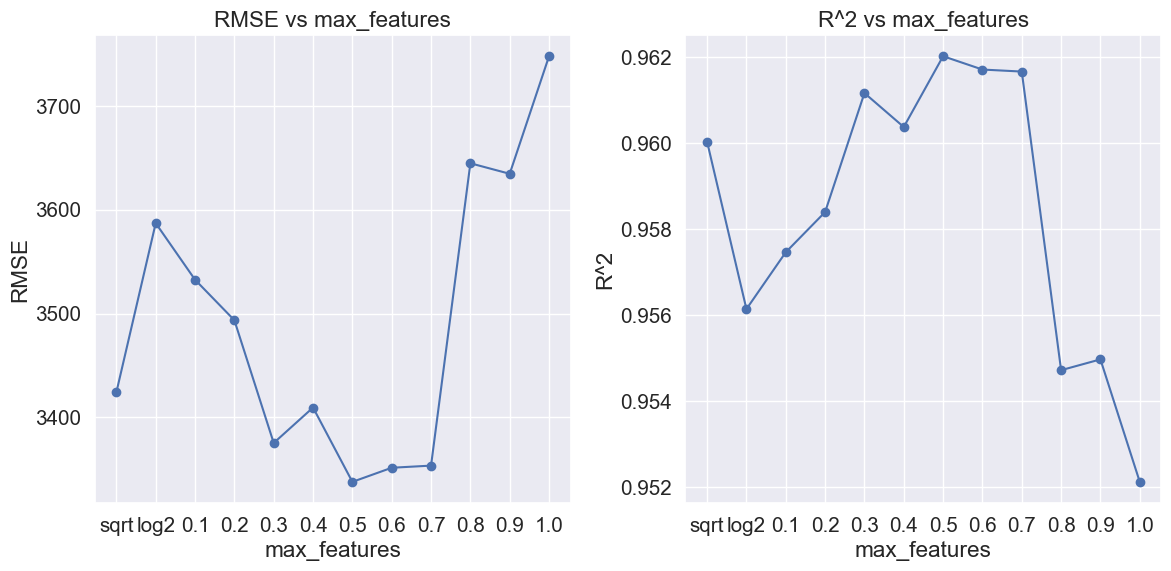

In [49]:
# plot the RMSE and R^2 score against the max_features parameter
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(max_features, rmse_list, marker='o')
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('RMSE vs max_features')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(max_features, r2_list, marker='o')
plt.xlabel('max_features')
plt.ylabel('R^2')
plt.title('R^2 vs max_features')
plt.grid(True)
plt.tight_layout()
plt.show()

Random Forest performs best when decorrelation is balanced. Setting max_features too low or too high both hurt model generalization.

R² peaks when max_features is around 0.5 to 0.6, in agreement with the RMSE plot.

R² drops at both ends:

* When using too few features → underfitting.

* When using all features (1.0) → overfitting from highly correlated trees.

In [50]:
# get the minimum RMSE and the corresponding max_features parameter
min_rmse = min(rmse_list)
min_rmse_index = rmse_list.index(min_rmse)
best_max_feature = max_features[min_rmse_index]
print(f'Minimum RMSE: {min_rmse:.2f}')
print(f'Best max_features: {best_max_feature}')
# get the maximum R^2 and the corresponding max_features parameter
max_r2 = max(r2_list)
max_r2_index = r2_list.index(max_r2)
best_max_feature_r2 = max_features[max_r2_index]
print(f'Maximum R^2: {max_r2:.2f}')
print(f'Best max_features: {best_max_feature_r2}')

Minimum RMSE: 3338.02
Best max_features: 0.5
Maximum R^2: 0.96
Best max_features: 0.5


## Other Hyperparameters

### Why bagging Uses Unpruned Trees

* Bagging’s strength is in reducing variance, not bias.

* Since deep, unpruned decision trees tend to overfit (high variance), bagging them averages out this variance effectively.

* Using pruned trees reduces variance and increases bias — but bagging is not good at correcting bias, so this would weaken performance.

>🔁 So in bagging, it's common to let each tree grow fully to preserve low bias, and rely on bagging to handle the variance.

### Hyperparameters that controls the complexity of tree in Random Forest

| Setting                    | Effect                             | Applies to       |
|---------------------------|-------------------------------------|------------------|
| `max_depth=None`          | Full trees, low bias, high variance | Bagging, RF      |
| `max_depth=some int`      | Pruned trees, more bias, less variance | Especially helpful in RF |
| `min_samples_split/leaves`| Prevents small branches             | Both             |

### Why randome forest often limits tree depth

Because only a subset of features is used at each split, fully grown Random Forest trees tend to overfit more than bagged trees that use all features. So limiting tree complexity in Random Forest:

* Prevents deep trees from chasing noise in sparse feature subsets.

* Improves generalization, especially on high-dimensional or noisy data.

###  Tuning Multiple Hyperparameters Simultaneously Using Cross-Validation

Given the number of hyperparameters involved, to reduce computational cost, we will use `BayesSearchCV` for tuning.


In [37]:
# hyperparameter tuning for the random forest regressor

from skopt.space import Integer, Categorical, Real
from skopt import BayesSearchCV

# Rename the pipeline step for clarity (recommended)
random_forest_regressor = RandomForestRegressor(
    random_state=42
)

randome_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', random_forest_regressor)  # Renamed from 'bagging' to 'rf'
])

param_space = {
    # Tree structure (control complexity)
    "rf__max_depth": Integer(5, 35),  
    "rf__min_samples_split": Integer(2, 20),
    "rf__min_samples_leaf": Integer(1, 10),
    "rf__max_features": Real(0.1, 1.0),
    
    # Ensemble settings
    "rf__n_estimators": Integer(20, 60),
    
    # Advanced
    "rf__max_samples": Real(0.1, 1.0),
}

opt = BayesSearchCV(
    randome_forest_pipeline,
    param_space,
    n_iter=50,  # Adjust based on computational resources
    cv=5,
    n_jobs=-1,
    random_state=42
)
opt.fit(X_train, y_train)  

# make predictions on the test data
y_pred = opt.predict(X_test)
# calculate the RMSE and R^2 score
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')
# calculate the training rmse and r^2 score
y_train_pred = opt.predict(X_train)
train_rmse = root_mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training R^2: {train_r2:.2f}')

RMSE: 3278.42
R^2: 0.96
Training RMSE: 1220.88
Training R^2: 0.99


As observed in the results, RMSE was further reduced after simultaneously tuning multiple hyperparameters. However, due to the small and simple nature of the dataset, the performance improvement is marginal. On larger and more complex datasets, the difference in performance would likely be more substantial

## Feature Important

In [57]:
# assume numerical_feature and categorical_feature are the original lists
num_features = numerical_feature
cat_transformer = opt.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_transformer.get_feature_names_out(categorical_feature)

# concatenate all feature names
feature_names = np.concatenate([num_features, cat_features])


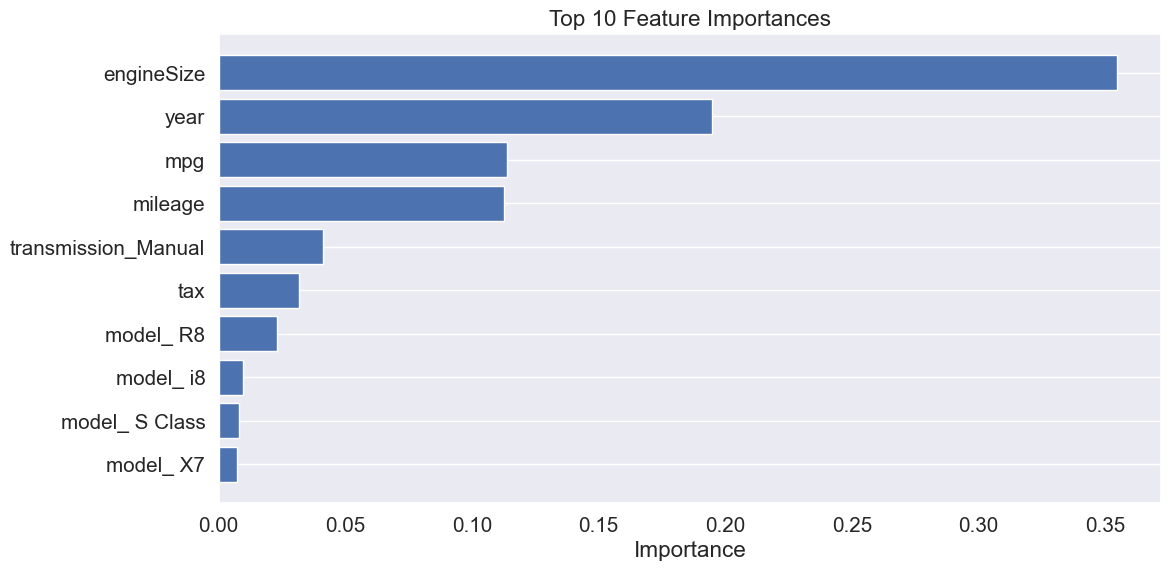

In [59]:
# output feature importances

importances = opt.best_estimator_.named_steps['rf'].feature_importances_
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['importance']).sort_values('importance', ascending=False)

# select top 10 features
top_10 = feature_importances.head(10)

# plot the top 10 feature importances
plt.figure(figsize=(12, 6))
plt.barh(top_10.index[::-1], top_10['importance'][::-1])  # reverse for top-to-bottom order
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


**In Summary**

Random Forest is a special case of bagging. The `n_estimators` and `oob_score` hyperparameters function similarly in both methods. In this notebook, we focused on the key differences between Random Forest and standard bagging.  
Random Forest generally outperforms bagging because it **decorrelates** the individual decision trees by randomly selecting a subset of features at each split, which **increases diversity** among the trees and **further reduces variance**.
